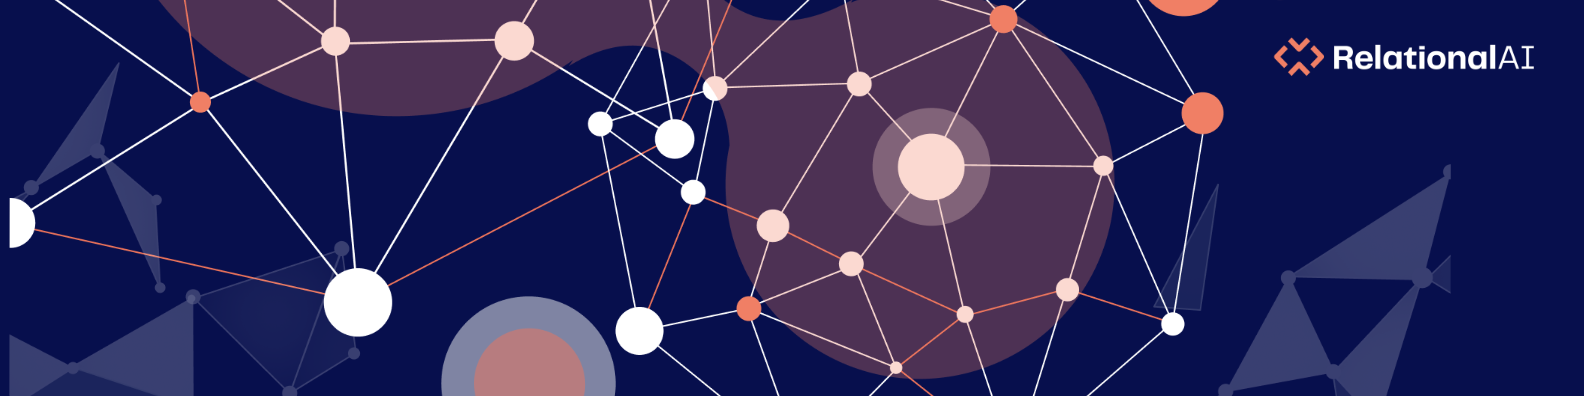
<!--Temporary solution to see the image in Github preview in private repo-->


<!-- <img src="assets/rai_banner.png"> This way Github preview should show image correctly for public repo -->

# Data Harmonization & Cleansing

## Overview
Different data providers usually use different master data attributes, such as keys, number ranges or descriptions. For example, the flavor of a certain chocolate bar could be called “Milk & Hazelnut” by the manufacturer. The different retailers and syndicated data providers might have other names for the product, such as “Milk/Hazelnut” or “MILK_HAZELNUT”.

This notebook demonstrates how RelationalAI can be used to link all the attributes that refer to the same attribute (e.g. same manufacturer or brand) to one single record that exclusively identifies the object, no matter in which data source it appeared and independent from its description or ID that was provided. After harmonizing all the attributes, we will demonstrate how to use the cleaned up master attributes to detect duplicate items.

We are going to:
- Demonstrate the **tight integration between Snowflake and RelationalAI** for running graph analytics on top of the Snowflake data, right where it lives.
- Use the Levenshtein metric to detect similar raw attributes values.
- Group raw product attributes that are aliases to the same attribute value using the weakly connected graph algorithm to create a harmonized set of product attributes.
- Detect potentially identical items in order to create a clean product item master.

## Let's get started!

### Importing Packages 
We start by installing and importing all the Python packages and modules that we will need, including the `relationalai` package. We then define the `DataHarmonizationLindt` model object.


> **Note**. Models represent collections of objects. Objects, like Python objects, have types and properties, which we will define in a bit.

In [1]:
import os

def install_packages():
    os.system("pip install relationalai matplotlib")

install_packages()

When you first run this notebook, go to the Appendix at the end of the notebook and run the cells there to complete the data setup steps.

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std.aggregates import sum, count, max, min, rank_asc, top
from relationalai.std import alias
from relationalai.std import rel, strings
from typing import Tuple
import matplotlib as mpl

model = rai.Model("DataHarmonizationLindt")

### Referencing Snowflake Data

**Note: the Appendix at the end of this notebook has some SQL code and a RelationalAI CLI invocation to create the tables in Snowflake and the data stream with RelationalAI. If no one has done those steps for your account yet, be sure to do that before proceeding.**

Due to RelationalAI's tight integration with Snowflake, we can access the imported relation in RAI by simply specifying source when creating a type `source="<my_database.my_schema.my_table>"`

In [3]:
RawItem = model.Type("RawItem", source="rai_demo.data_harmonization.items")

> **Note**. We connect to Snowflake and create a Snowpark session using the `rai init` command. A `data stream` between the table `items` and the `DataHarmonizationLindt` model was created to stream the data from Snowflake to the RAI schema.

### Defining Types
Now that we know how to refer to our data within RAI, let's define our `Types`. You can think of types as representing real world entities, that is to say, things that you want to use in your model. Our input data contains `RawItems` and their `RawAttributes`. Once we manage to de-duplicate our data, we are going to create `Items` as well `Attributes`, we're therefore declaring those types already here, too.


> **Note**. Types are collections of objects. You create them using the `model.Type()` method, which returns an instance of the `Type` class.

In [4]:
RawAttribute = model.Type('RawAttribute')

Item = model.Type('Item')
Attribute = model.Type('Attribute')

Brand = model.Type('Brand')
Category = model.Type('Category')

## Getting to know the raw input data
Let's write a small query to take a look at the raw data.

In [5]:
with model.query() as select:
    item = RawItem()
    res = select(
        item.id,
        item.source,
        item.raw_description,
        item.subbrand,
        item.brand,
        item.mfr,
        item.unit,
        item.pack_size,
        item.pack_type,
        item.chocolate_type,
        item.flavor,
        item.sub_category,
        item.category,
    )

res.results.head(10)

id    source                                    raw_description  \
0   AD02434302  AmazonDE                                 Lindt P&M Box 500g   
1   AU02479305  AmazonUK                Lindt Pick & Mix Selection Box 500g   
2  AU104147282  AmazonUK                           Lindt Gold Milk Bar 300g   
3  AU104150361  AmazonUK                  Lindt Pick And Mix Heart Tin 550g   
4   AU11382097  AmazonUK    Choco Wafer Milk Chocolate Hazelnut Sharing Box   
5   AU11926835  AmazonUK                  Lindt EXCELLENCE Dark 99% Bar 50g   
6    AU1213618  AmazonUK  Lindt LINDOR Strawberries Cream Chocolate Truf...   
7  AU123257327  AmazonUK                    Lindt NUXOR Dark Chocolate 165g   
8  AU146611642  AmazonUK              Lindor Double Chocolate Truffles 200g   
9  AU162967556  AmazonUK                 Lindt EXCELLENCE Dark 90% Bar 100g   

           subbrand             brand                  mfr      unit  \
0    Lindt Pick_Mix  Lindt & Sprüngli  Lindt & Sprüngli Sw         g   
1  Lindt Pick & Mix    Lindt_Sprungli     Lindt _ Sprungli         g   
2        Lindt GOLD    Lindt_Sprungli  Lindt & Sprungli ag         g   
3  Lindt Pick & Mix    Lindt_Sprungli     Lindt & Sprungli         g   
4       CHOCO WAFER    Lindt_Sprungli  Lindt & Sprüngli AG  truffles   
5  Lindt EXCELLENCE    Lindt_Sprungli  Lindt & Sprungli ag         g   
6      Lindt LINDOR    Lindt_Sprungli               Lindor         g   
7             Nuxor    Lindt_Sprungli  Lindt & Sprüngli CH         g   
8      Lindt LINDOR    Lindt_Sprungli               Lindor         g   
9  Lindt EXCELLENCE    Lindt_Sprungli  Lindt & Sprungli ag         g   

  pack_size     pack_type chocolate_type             flavor  \
0      500g  Assorted_Box          mixed           Assorted   
1      500g  Assorted Box           Dark             Assor.   
2      300g           bar           Milk   Milky Sweet Choc   
3      550g  Assorted Box          mixed            Assort.   
4        50  Assorted Box           Milk      Milk Hazelnut   
5       50g           bar           Dark   Extra Dark Cocoa   
6      200g           box          mixed           Assorted   
7      165g           bar           Dark  Dark Bitter Cocoa   
8      200g           box          mixed           Assorted   
9      100g           bar           Dark    Extra Dark Choc   

                       sub_category               category  
0  Chocolate Candy Assortment Boxes     Chocolates & Candy  
1  Chocolate Candy/Assortment Boxes   Chocolates and Candy  
2                    Chocolate Bars   Chocolates and Candy  
3  Chocolate Candy/Assortment Boxes  Food & Beverage Gifts  
4  Chocolate Candy/Assortment Boxes  Food & Beverage Gifts  
5                    Chocolate Bars   Chocolates and Candy  
6  Chocolate Candy/Assortment Boxes  Food & Beverage Gifts  
7                    Chocolate Bars   Chocolates and Candy  
8  Chocolate Candy/Assortment Boxes  Food & Beverage Gifts  
9                    Chocolate Bars   Chocolates and Candy

## Weaving the data into the model
Let’s weave our data into our model. We do this by writing some rules. **Rules describe objects in a model and the relationships between them**. We start by defining `RawAttributes` and how they are linked to `RawItems`.

> **Note**. Rules are created using the `model.rule()` context manager. For each column defined in `COLUMN_LIST`, we create a new object of type `RawAttribute`, using `RawAttribute.add()` and providing properties that uniquely identify a single attribute (`id` - for its value, and `type` - for the name of the column it represents). Then, we add it to `has_raw_attribute` property of `RawItem` to link the attributes to it.

In [6]:
# List of attributes that we want to create from the input data
COLUMN_LIST = ['subbrand', 'brand', 'mfr', 'unit', 'pack_size', 'pack_type', 'chocolate_type', 'flavor', 'sub_category', 'category']

for column in COLUMN_LIST:
    with model.rule():
        i = RawItem()
        i.has_raw_attribute.add(RawAttribute.add(id = getattr(i, column), type= column))

Lets write a small query that returns the number of raw items, attributes and their types we just added to our model.

In [7]:
with model.query() as select:
    i = RawItem()
    r = RawAttribute()
    result = select(alias(count(i.source),'Sources'), alias(count(i),'Items'), alias(count(r),'Attributes'), alias(count(r.type),'Attribute Types'))
result

> **Tip**. Our dataset consists of 190 items from 3 different sources. There are in total 149 different product attribute values, spread over 10 different attribute types (e.g. `brand`, or `flavor`) 

## Deriving missing attributes using attribute hierarchies
One common problem when trying to harmonize data from different sources is that they are not always providing the same data points (e.g. attributes, in our case). One dataset might provide both the subbrand and the brand of an item, while the second one for instance only the subbrand. Given that there's a relationship between a `subbrand` and a `brand`, we can use this information to derive missing values.

Let's first write a query to see if/how many of our items are impacted.

In [8]:
with model.rule():
    r_item = RawItem()
    c = count(r_item.has_raw_attribute, per=[r_item])
    r_item.set(number_of_attributes = c)

with model.query() as select:
    r_item = RawItem()
    r_item.number_of_attributes < 10
    res = select(count(r_item))
res

There are some attributes in our dataset that have a relationship with, i.e. 'roll up to' another attribute:
- A `subbrand` maps to a `brand` and
- a `subcategory` maps to a `category`.

We can write rules to create a relationship between these attributes. 

In [9]:
with model.rule():
    r_item = RawItem()
    r_brand = RawAttribute(type = 'brand')
    r_subbrand = RawAttribute(type = 'subbrand')
    with model.found():
        r_item.has_raw_attribute == r_brand
    with model.found():
        r_item.has_raw_attribute == r_subbrand
    r_subbrand.set(maps_to = r_brand)

with model.rule():
    r_item = RawItem()
    r_category = RawAttribute(type = 'category')
    r_sub_category = RawAttribute(type = 'sub_category')
    with model.found():
        r_item.has_raw_attribute == r_category
    with model.found():
        r_item.has_raw_attribute == r_sub_category
    r_sub_category.set(maps_to = r_category)

# query all mappings
with model.query() as select:
    r_attr = RawAttribute()
    res = select(alias(r_attr.type,"attr. type"), alias(r_attr.id,"attribute"), alias(r_attr.maps_to.type,"maps to type"), alias(r_attr.maps_to.id,"maps to attr."))
res

Now that we have defined the hierarchical relationships, let's tag all items that have either a missing brand or a missing category, so that we can easily refer to them, and check how many we have in our dataset for each of them.

In [10]:
ItemWithMissingAttribute = model.Type('ItemWithMissingAttribute')

with model.rule():
    r_item = RawItem()
    with model.not_found():
        r_attr = r_item.has_raw_attribute
        r_attr == RawAttribute(type='brand')
    r_item.set(ItemWithMissingAttribute)

with model.rule():
    r_item = RawItem()
    with model.not_found():
        r_attr = r_item.has_raw_attribute
        r_attr == RawAttribute(type='category')
    r_item.set(ItemWithMissingAttribute)

with model.query() as select:
    ma = ItemWithMissingAttribute()
    res = select(alias(count(ma),"nr. of items with a missing attribute"))
res.results

nr. of items with a missing attribute
0                                      3

> **Tip**. We found 3 items that have either a missing brand, or a missing category.

### Populating missing hierarchical attributes
For items with a missing brand, where the subbrand is known, we can derive the brand from the subbrand through the new hierarchy that we created. Similary, if the subcategory of an item is known, we can derive its category via the mapping between these two attributes. 


In [11]:
with model.rule():
    r_item = ItemWithMissingAttribute()
    r_attr = RawAttribute()
    r_attr == r_item.has_raw_attribute
    r_attr_to = r_attr.maps_to
    r_item.has_derived_attribute.add(r_attr_to)

with model.rule():
    r_item = RawItem()
    with model.union() as attributes:
        with r_item.has_raw_attribute:
            attributes.add(r_item.has_raw_attribute)
        with r_item.has_derived_attribute:
            attributes.add(r_item.has_derived_attribute)
    r_item.has_attribute.add(attributes)

Lets's write a query to validate that we have now derived the missing attributes for the affected items.

In [12]:
with model.rule():
    r_item = RawItem()
    c_attr = count(r_item.has_derived_attribute, per=[r_item])
    r_item.set(number_of_derived_attributes = c_attr)

with model.query() as select:
    r_item = RawItem()
    c_r_attr = sum(r_item, r_item.number_of_attributes)
    c_d_attr = sum(r_item,r_item.number_of_derived_attributes.or_(0))
    c = count(r_item.has_attribute, per =[r_item])
    c_attr = sum(r_item, c)
    res = select(alias(c_r_attr,"nr.of raw attr"), alias(c_d_attr,"nr.of derived attr"), alias(c_attr,"nr. of raw + derived attr"))
res.results

nr.of raw attr  nr.of derived attr  nr. of raw + derived attr
0            1896                   6                       1901

> **Tip**. We had 1896 raw attributes and successfully derived 6 attributes values from them: for every item with any missing attribute we added derived `brand` and `category` attributes. Then we combined the two sets in a final `has_attribute` set for every item and got in total 1901 attributes, which means 1 of the attributes we *derived* was already known from the raw data.

### Visualizing the input data as a Graph

Pictures speak louder than words, so let's visualize our input data as a graph. Both items as well as their attributes are repsented as nodes in the graph. Edges represent the link between an item and its attributes.

In [13]:
input_graph = Graph(model)
Node, Edge = input_graph.Node, input_graph.Edge

Node.extend(RawAttribute, label = RawAttribute.id)
Node.extend(RawItem, label = RawItem.raw_description, color='red')
Edge.extend(RawItem.has_raw_attribute)

input_graph.visualize()

> **Tip**. Our graph looks quite messy, to be honest. Nodes referring to attributes are represented in black, items in red. You can see how there are multiple edges pointing at certain attributes, this indicates that there are multiple items with that specific attribute. 
> 
> It's quite hard, though, to derive any useful conclusions from this.

### Can we rely on the 'Description' attribute to find duplicate items?
Given that we are receiving data from multiple different sources, we expect that there are a some duplicate items. The easiest way to try to search for them is by comparing their descriptions. So let's query how many items we have with duplicate descriptions.

In [14]:
with model.query() as select:
    i1 = RawItem()
    i2 = RawItem()
    i1.raw_description == i2.raw_description
    i1.id != i2.id
    result = select(i1.id, alias(i1.raw_description, "description"))
result.results.head(10)

id                                        description
0   AU02479305                Lindt Pick & Mix Selection Box 500g
1  AU162967556                 Lindt EXCELLENCE Dark 90% Bar 100g
2  AU314518253                    Lindt COOKING 51% Dark Bar 200g
3  AU333279491  Lindt CLASSIC Vegan Caramel Sea Salt Chocolate...
4   AU45680846  Lindt EXCELLENCE Raspberry Hazelnut 70% Cocoa ...
5  AU465544674    Lindt EXCELLENCE Dar Raspberry Intense Bar 100g
6  AU471181412                 Lindt EXCELLENCE Dark 70% Bar 100g
7  AU514775354                Lindt Nuxor Milk Chocolate Hazelnut
8  AU523361876                Lindt Nuxor Milk Chocolate Hazelnut
9  AU536940991         Lindt EXCELLENCE Caramelised Hazelnut 100g

To better our understand our problem, let's create a new graph, where we only show items that have one of these duplicate descriptions, and visualize it.

> **Note**. We define a new **Type** called `DemoItem` and write a rule to tag all items with a certain description as such. We then run a query to confirm that the rule was applied correctly.

In [15]:
DemoItem = model.Type("DemoItem")

with model.rule():
    i = RawItem()
    i.raw_description == "Lindt Pick & Mix Selection Box 500g"
    i.set(DemoItem)

with model.query() as select:
    i = DemoItem()
    result = select(i.id, i.source)
result

In [16]:
# function to color nodes based on a property of the node.

def color_nodes(graph, by: str, cmap = mpl.cm.rainbow, default: str = "black"):
    # Normalize the values of the property `by` to [0, 1] and set
    # the `color` property` of each node to the normalized value.
    with graph.model.rule():
        node = graph.Node()
        node.set(prop_rank = rank_asc(getattr(node, by)))

    with graph.model.rule():
        node = graph.Node()
        min_ = min(node.prop_rank)
        max_ = max(node.prop_rank)
        normalized = (node.prop_rank - min_) / (max_ - min_)
        node.set(color=normalized)

    # Define a function that returns the color of a node based on
    # its `color` property. Colors are determined by the `cmap`
    # colormap. If a node does not have the `color` property,
    # the`default` color is returned.
    def _color(node):
        if node.get("color") is not None:
            return mpl.colors.to_hex(cmap(node['color']))
        else:
             return default

    return _color

In [17]:
demo_graph = Graph(model)
D_Node, D_Edge = demo_graph.Node, demo_graph.Edge

D_Node.extend(DemoItem, label = RawItem.raw_description, size=20)

with model.rule():
    i = DemoItem()
    a = RawAttribute()
    a == i.has_raw_attribute
    D_Edge.add(from_= i, to = a, label = a.id, hover=a.id )
    D_Node.add(a, label=a.id, hover = a.type, type = a.type)


demo_graph.visualize(style={"node": {"color": color_nodes(demo_graph, by="type") }})

> **Tip**. It is indeed as we feared. While the item descriptions are the same, the attributes that we are receiving from our sources do not fully match. They are quite similar though, if you look at them closely! Given that we want to be able to automatically detect identical items, we need to make sure that not just the description of the item matches, but the attributes, too. Let's therefore try to clean up our attribute list.

## Detecting similar attributes

The Levenshtein distance is a very useful metric when trying to compare strings. It defines the distance between two words as the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. Let's run it on all of our attributes (grouped by attribute type), to see if we can find some `related` attributes.


> **Note**. We compare each attribute to other attributes of the same type using levenshtein distance. This fuzzy matching produces a score of how similar these two node are. Here we defining attributes as related if they match at 70% or higher.

In [18]:
LEVENSHTEIN_COLUMNS_LIST = ['subbrand','brand','mfr','unit','pack_type','chocolate_type','flavor','sub_category','category']

with model.rule():
    att1 = RawAttribute()
    att2 = RawAttribute()
    att1.type == att2.type
    att1.type.in_(LEVENSHTEIN_COLUMNS_LIST)
    att1 != att2
    lev = rel.levenshtein(rel.lowercase(att1.id),rel.lowercase(att2.id))
    percent = lev / rel.maximum(strings.length(att1.id), strings.length(att2.id))
    percent < 0.30
    att1.is_related_to.add(att2)


with model.query() as select:
    att = RawAttribute()
    res = select(att.type, alias(att.id, "attribute"), alias(att.is_related_to.id, "related attribute"))
res.results.head(10)

type             attribute     related attribute
0           brand      Lindt & Sprüngli        Lindt_Sprungli
1           brand        Lindt_Sprungli      Lindt & Sprüngli
2        category    Chocolates & Candy  Chocolates and Candy
3        category    Chocolates & Candy     Chocolates, Candy
4        category  Chocolates and Candy    Chocolates & Candy
5        category  Chocolates and Candy     Chocolates, Candy
6        category     Chocolates, Candy    Chocolates & Candy
7        category     Chocolates, Candy  Chocolates and Candy
8  chocolate_type               4-White                 White
9  chocolate_type               5-Vegan                 Vegan

> **Tip**. Success! We found indeed some very similar attribute values that should serve as an alias to a single attribute value.

## Deriving final attributes using weakly connected components
We can use one of RelationalAI's built-in graph algorithms, such as `weakly connected components`, to group all the raw attribute values that are related. 

For each of the groups we create an `Attribute`. We also create a link between each `RawAttribute` and `Attribute` by adding the `is_alias_of` property - as raw attribute values function as an alias to the actual attribute value.

> **Note**. Running a graph algorithm is as simple as creating a graph, defining its nodes and edges, and then using the graph's `.compute` object, which contains the methods for computing graph analytical functions, such as `weakly_connected_component`.

In [19]:
wcc_graph = Graph(model, undirected=True, with_isolated_nodes=True)
wcc_Node, wcc_Edge = wcc_graph.Node, wcc_graph.Edge

with model.rule():
    r_attr = RawAttribute()
    r_attr.type.in_(LEVENSHTEIN_COLUMNS_LIST)
    wcc_Node.add(r_attr, label = r_attr.id)

with model.rule():
    r_attr = RawAttribute()
    r_attr.type.in_(LEVENSHTEIN_COLUMNS_LIST)
    wcc_Edge.add(r_attr, r_attr.is_related_to)

with model.rule():
    r_attr = RawAttribute()
    r_attr.type.in_(LEVENSHTEIN_COLUMNS_LIST)
    community = wcc_graph.compute.weakly_connected_component(r_attr)
    attr = Attribute.add(id=community)
    r_attr.set(is_alias_of = attr)
    wcc_Node(r_attr).set(community = community)

wcc_graph.visualize(style={"node": {"color": color_nodes(wcc_graph, by="community") }})

> **Tip**. All the related raw attributes are much clearer to see in a visualization than in a table. Look at all these different ways that the `Caramel Sea Salt` flavor is used!

### Rules to derive the `type` and the final attribute value

Given that all `RawAttributes` that map to a final attribute have the same type, we can make sure that the final attribute inherits this value from them.

In [20]:
# make sure that our new Attributes inherit the type property from the raw attributes
with model.rule():
    r_attr = RawAttribute()
    attr = Attribute()
    r_attr.is_alias_of == attr
    attr.set(type= r_attr.type)

For the actual value of the final attribute, the situation is trickier, as each `RawAttribute` will refer to a different value. We therefore will use the value that is used most frequently.

In [21]:
# count of items per attribute
with model.rule():
    r_attr = RawAttribute()
    r_item = RawItem()
    r_item.has_raw_attribute == r_attr
    c = count(r_item, per=[r_attr])
    r_attr.set(item_count=c)

# use the most common RawAttribute for the attribute
with model.rule():
    r_attr = RawAttribute()
    attr = Attribute()
    r_attr.is_alias_of == attr
    r_attr.item_count == max(r_attr.item_count, per=[attr])
    v = top(1, r_attr, per=[attr])
    r_attr.set(rank = v)
    r_attr.rank == 1
    attr.set(value = r_attr.id)

### Visualizing the impact of grouping similar attributes
Let's visualize our graph with the 2 items that have a matching description and let's see if all of their (final) attributes match, which would thus indicate that these are indeed identical items.

In [22]:
clean_attr_graph = Graph(model)
CA_Node, CA_Edge = clean_attr_graph.Node, clean_attr_graph.Edge

CA_Node.extend(DemoItem, label = RawItem.raw_description, size=20)

with model.rule():
    i = DemoItem()
    r_attr = RawAttribute()
    i.has_attribute == r_attr
    CA_Node.add(r_attr, label=r_attr.id, type = r_attr.type)

with model.rule():
    i = DemoItem()
    r_attr = RawAttribute()
    r_attr = i.has_attribute
    r_attr.type == 'pack_size'
    CA_Edge.add(from_= i, to = r_attr)

with model.rule():
    i = DemoItem()
    r_attr = RawAttribute()
    r_attr = i.has_attribute
    f_attr = r_attr.is_alias_of
    CA_Edge.add(from_= i, to = f_attr)
    CA_Edge.add(from_= f_attr, to = r_attr)
    CA_Node.add(f_attr, label = f_attr.value)

clean_attr_graph.visualize(style={"node": {"color": color_nodes(clean_attr_graph, by="type") }})

> **Tip**. Looking at these two items with matching descriptions, it turns out that they should not be the same item. If you take a close look at the attributes, most of them are the same, but `flavor` is actually different!

You can also see how we successfully resolved the Manufacturer and the Brand to the same entity.

## Detecting identical items using Jaccard similarity

We now know that we can't simply rely on comparing descriptions of items to detect whether they are identical. Instead, item attributes will need to be taken into consideration.

Given that we have our data available as a graph, and we have cleaned up our attributes already, we can use the Jaccard similarity algorithm to find items with a high similarity score. Let's compare our demo item against all the items in our database to see if we can find some similar items.


> **Note**. The Jaccard Similarity is a metric of similarity for two sets of data. In the graph, collecting the neighbors of a node into a set, two nodes are considered similar if their neighbor sets are similar.

In [23]:
js_graph = Graph(model, undirected=True)
JS_Node, JS_Edge = js_graph.Node, js_graph.Edge

JS_Node.extend(RawItem)
JS_Node.extend(RawAttribute)

with model.rule():
    i = RawItem()
    r_attr = RawAttribute()
    r_attr = i.has_attribute
    r_attr.type == 'pack_size'
    JS_Edge.add(from_= i, to = r_attr)

with model.rule():
    i = RawItem()
    r_attr = RawAttribute()
    r_attr = i.has_attribute
    f_attr = r_attr.is_alias_of
    JS_Edge.add(from_= i, to = f_attr)
    JS_Node.add(f_attr)

with model.rule():
    i1 = RawItem()
    i2 = RawItem()
    i1 != i2
    similarity_score = js_graph.compute.jaccard_similarity(i1, i2)
    similarity_score>0.99
    i1.is_similar_to.add(i2)


In [24]:
with model.query() as select:
    i1 = DemoItem()
    i2 = i1.is_similar_to
    res = select(alias(i1.id, "id (item)"), alias(i2.id, "id (similar item)"), alias(i1.raw_description, "description (item)"), alias(i2.raw_description, "description (similar item)"))
res

> **Tip**. By running the Jaccard Similarity algorithm, we actually found an item that seems to have a 100% match based on its attributes with the item that we were looking at earlier. The descriptions of these aren't matching, that's why this second item did not show up earlier during our analysis.

### Visualizing two similar items with different description
As we know that both of these items are similar, it's also clear that description is not the same. Lets visualize them with their attributes.

In [25]:
viz_graph  = Graph(model, undirected=True)
viz_Node, viz_Edge = viz_graph.Node, viz_graph.Edge

IDS = ['WM594737608', 'AD02434302']

# pack_size does not have an Attribute
with model.rule():
    i = RawItem()
    i.id.in_(IDS)
    r_attr = RawAttribute()
    r_attr = i.has_attribute
    r_attr.type == 'pack_size'
    viz_Node.add(r_attr, label=r_attr.id, type = r_attr.type)
    viz_Edge.add(from_= i, to = r_attr)

with model.rule():
    i = RawItem()
    i.id.in_(IDS)
    viz_Node.add(i, label = i.raw_description, size=20)

with model.rule():
    i = RawItem()
    i.id.in_(IDS)
    r_attr = RawAttribute()
    i.has_attribute == r_attr
    viz_Node.add(r_attr, label=r_attr.id, type = r_attr.type)

with model.rule():
    i = RawItem()
    i.id.in_(IDS)
    r_attr = RawAttribute()
    r_attr = i.has_attribute
    f_attr = r_attr.is_alias_of
    viz_Edge.add(from_= i, to = f_attr)
    viz_Edge.add(from_= f_attr, to = r_attr)
    viz_Node.add(f_attr, label = f_attr.value)

viz_graph.visualize(style={"node": {"color": color_nodes(viz_graph, by="type") }})

> **Tip**. It is clear that this is a duplicate item. They both have the exact same RawAttributes that we resolved to the same Attribute.

## Uniquely identifing items with WCC
Now that we know what items are similar we can use `wcc` (weakly connected components) again to uniquely identify each group of items. We use this to create new entities of Type `Item`.

In [26]:
# use_this_some_other_place = ['raw_pack_size','raw_weight']
wcc_2_graph = Graph(model, undirected=True, with_isolated_nodes=True)
wcc_2_Node, wcc_2_Edge = wcc_2_graph.Node, wcc_2_graph.Edge

wcc_2_Node.extend(RawItem, label = RawItem.raw_description)
wcc_2_Edge.extend(RawItem.is_similar_to)

with model.rule():
    raw_item = RawItem()
    cluster = wcc_2_graph.compute.weakly_connected_component(raw_item)
    item = Item.add(id = cluster)
    raw_item.set(is_alias_of=item)
    wcc_2_Node(raw_item).set(cluster=cluster)

wcc_2_graph.visualize(style={"node": {"color": color_nodes(wcc_2_graph, by="cluster") }})

## Conclusion
Let's run a final query to count the number of raw vs. unique items that we found, as well as raw attributes that we merged to unique attributes.

In [27]:
with model.query() as select:
    raw_item = RawItem()
    item = Item()
    r_attr = RawAttribute()
    attr = Attribute()
    res = select( alias(count(raw_item), 'raw items'), alias(count(item), 'unique items'), alias(count(r_attr), 'raw attributes'), alias(count(attr), 'unique attributes'))
res.results

raw items  unique items  raw attributes  unique attributes
0        190           155             149                 66

> **Tip**. We started with 190 unique `RawItem` and 149 unique `RawAttribute`. Through the process of resolving `Attributes` and then `Items` we identified 83 duplicate attributes and 35 duplicate items in out dataset thus reducing the total number of unique `Items` to 155 and unique `Attribute` to 66.

## Writing back results to Snowflake

In [28]:
@model.export("rai_demo.data_harmonization")
def similar_items() -> Tuple[str, str]:
    raw_item = RawItem()
    return raw_item.is_alias_of.id, raw_item.id

In [29]:
@model.export("rai_demo.data_harmonization")
def similar_attributes() -> Tuple[str, str, str, str]:
    raw_attr = RawAttribute()
    return raw_attr.is_alias_of.id, raw_attr.is_alias_of.value, raw_attr.id, raw_attr.type

# Appendix

## Inserting data

In [30]:
import relationalai

DO_SETUP = False

create_schema_commands = """
create database if not exists RAI_DEMO;
create schema if not exists RAI_DEMO.DATA_HARMONIZATION;
"""

create_table_command = """
create or replace table RAI_DEMO.DATA_HARMONIZATION.ITEMS (
	ID TEXT,
	SOURCE TEXT,
	RAW_DESCRIPTION TEXT,
	SUBBRAND TEXT,
	BRAND TEXT,
	MFR TEXT,
	UNIT TEXT,
	PACK_SIZE TEXT,
	PACK_TYPE TEXT,
	CHOCOLATE_TYPE TEXT,
	FLAVOR TEXT,
	SUB_CATEGORY TEXT,
	CATEGORY TEXT
);
"""

insert_data_command = """
insert into RAI_DEMO.DATA_HARMONIZATION.ITEMS (source, id, raw_description, subbrand, brand, mfr, unit, pack_size, pack_type, chocolate_type, flavor, sub_category, category) VALUES ('AmazonDE', 'AD02434302', 'Lindt P&M Box 500g', 'Lindt Pick_Mix', 'Lindt & Sprüngli', 'Lindt & Sprüngli Sw', 'g', '500g', 'Assorted_Box', 'mixed', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Chocolates & Candy'),
('AmazonUK', 'AU02479305', 'Lindt Pick & Mix Selection Box 500g', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt _ Sprungli', 'g', '500g', 'Assorted Box', 'Dark', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Chocolates and Candy'),
('AmazonUK', 'AU104147282', 'Lindt Gold Milk Bar 300g', 'Lindt GOLD', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '300g', 'bar', 'Milk', 'Milky Sweet Choc', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU104150361', 'Lindt Pick And Mix Heart Tin 550g', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt & Sprungli', 'g', '550g', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU11382097', 'Choco Wafer Milk Chocolate Hazelnut Sharing Box', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'truffles', '50', 'Assorted Box', 'Milk', 'Milk Hazelnut', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU11926835', 'Lindt EXCELLENCE Dark 99% Bar 50g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '50g', 'bar', 'Dark', 'Extra Dark Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU1213618', 'Lindt LINDOR Strawberries Cream Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU123257327', 'Lindt NUXOR Dark Chocolate 165g', 'Nuxor', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '165g', 'bar', 'Dark', 'Dark Bitter Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU146611642', 'Lindor Double Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU162967556', 'Lindt EXCELLENCE Dark 90% Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Extra Dark Choc', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU164316096', 'Lindt CREATION Bars Bundle 3x150g', 'CREATION', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '150g', 'bars bundle', 'mixed', 'Assorted', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU165624499', 'Lindt LINDOR Milk Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Milk', 'Milky Sweet Choc', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU186420287', 'Lindt LINDOR Milk Bar 38g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '38g', 'bar', 'Milk', 'Milk Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU197963876', 'Lindt Swiss Luxury chocolate box open with milk white and dark chocolates inside', 'Swiss Luxury', 'Lindt_Sprungli', 'Lindt & Sprungli', 'truffles', '50', 'Assorted Box', 'Milk', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU216515402', 'Lindt Dark Chilli Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Chili', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU222874420', 'Lindt CREATION Creme Brulee Bar 150g', 'CREATION', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '150g', 'bar', 'Milk', 'Creme Brulee', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU22877574', 'Lindt Dark Caramel Sea Salt Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Caramel Salt', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU233807744', 'Lindt LINDOR White Bar 100g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '100g', 'bar', 'White', 'Vanilla White Chocolate', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU234536668', 'Lindt CLASSIC RECIPE Milk Sharing Bar 190g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '190g', 'bar', 'Milk', 'Milky Sweet Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU237300376', 'Lindt EXCELLENCE 70% Flavours Bundle 3x100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Chocolates and Candy'),
('AmazonUK', 'AU263399065', 'Pick & Mix White Box 750g', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt & Sprungli', 'g', '750g', 'Assorted Box', 'White', 'Vanilla White Cocoa', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU272646426', 'Lindt LINDOR Milk Chocolate Truffles 37g', 'Lindt LINDOR', 'Lindt_Sprungli', 'LLINDOR', 'g', '37g', 'bar', 'Milk', 'Milk Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU275553949', 'Lindt Lindor Milk Chocolate Mint Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Milk', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU282107885', 'Lindt MINI PRALINES Spring Chocolate Box 180g', 'Selection', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '180g', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU286611974', 'Lindt LINDOR Assorted Chocolate Truffles 600g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '600g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU303592078', 'Lindt CLASSIC RECIPE Bars Bundle 3 x 100g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bars bundle', 'mixed', 'Assorted', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU304550294', 'Lindt LINDOR Favourites Bundle 5x200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'LLINDOR', 'g', '200g', 'bars', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Chocolates, Candy'),
('AmazonUK', 'AU309806859', 'Lindt Selection Chocolate Box 427g', 'Lindt Selection', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '427g', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU310556233', 'Lindt Dark Honeycomb Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Honey', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU314518253', 'Lindt COOKING 51% Dark Bar 200g', 'Lindt COOKING', 'Lindt_Sprungli', 'Lindt COOKING', 'g', '200g', 'bar', 'Dark', 'Bitter Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU316327272', 'Lindt NUXOR Milk Chocolate 165g', 'Nuxor', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '165g', 'bar', 'Milk', 'Milk Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU317480348', 'Lindt GRANDES Dark Hazelnut Bar 150g', 'Lindt LES GRANDES', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '150g', 'bar', 'Dark', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU325295394', 'Lindt GRANDES Milk Hazelnut Bar 150g', 'Lindt LES GRANDES', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '150g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU333279491', 'Lindt CLASSIC Vegan Caramel Sea Salt Chocolate Bar 100g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Vegan', 'Caramel Salted', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU348335019', 'Lindt LINDOR Blue Assorted Chocolate Truffles 337g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '337g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU354259215', 'LINDOR Milk Salted Caramel Chocolate Truffles 600g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '600g', 'box', 'Milk', 'Caramel Sea Salt', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU356241662', 'Cocoa Pod Tin White 450g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '450g', 'tin box', 'White', 'Vanilla White Choc', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU370859371', 'Lindt Gold Bars Bundle 3x300g', 'Lindt GOLD', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '300g', 'bars bundle', 'mixed', 'Assorted', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU379525932', 'Lindt Dark Cranberry Almond & Hazelnut Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Cranberry Almond and Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU383424054', 'Cocoa Pod Tin Red 450g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '450g', 'tin box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU385542311', 'Lindt CREATION Dessert Assorted Chocolate Box 341g', 'CREATION', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '341g', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU390078297', 'Lindt Dark Mint Intense Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Mint', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU391683348', 'Lindt LINDOR Assorted Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU437519096', 'Lindt Napolitains Chocolate Box 700g', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '700g', 'Assorted Box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU441391202', 'Lindt LINDOR White Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'White', 'Vanilla White', 'Chocolate Candy/Assortment Boxes', NULL),
('AmazonUK', 'AU447708847', 'Lindt Lindor Salted Caramel Treat Bar', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '100g', 'bar', 'Milk', 'Caramel Salty', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU45680846', 'Lindt EXCELLENCE Raspberry Hazelnut 70% Cocoa Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU457909844', 'Lindt LINDOR Milk Coconut Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Milk', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU463727127', 'Lindt Classic milk Hazelnut 100g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU465544674', 'Lindt EXCELLENCE Dar Raspberry Intense Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Raspberries', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU471181412', 'Lindt EXCELLENCE Dark 70% Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Bitter Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU479067657', 'Lindt LINDOR Assorted Chocolate Truffles 337g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '337g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU484705736', 'Lindt Lindor 60% Extra Dark Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Dark', 'Dark Bitter Cocoa', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU489269898', 'Cocoa Pod Tin Brown 450g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '450g', 'tin box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU511569867', 'Lindt Lindor Milk & White Lindor', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Milk', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU514775354', 'Lindt Nuxor Milk Chocolate Hazelnut', 'Nuxor', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'truffles', '50', 'Assorted Box', 'Milk', 'Milk with Hazelnut', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU520899059', 'Lindt Salted Caramel Bar 39g x 24', 'Lindt HELLO', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '39g x 24', 'bar', 'Milk', 'Caramel Salted', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU521046342', 'Lindt LINDOR Raspberry & Cream Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU523361876', 'Lindt Nuxor Milk Chocolate Hazelnut', 'Nuxor', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'truffles', '50', 'Assorted Box', 'Milk', 'Milk & Hazelnut', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU527029481', 'Lindt CLASSIC RECIPE Milk Crispy Bar 100g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Milk', 'Milky Swt. Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU536940991', 'Lindt EXCELLENCE Caramelised Hazelnut 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU553621598', 'Lindt CREATION Dark Pistachio Bar 150g', 'CREATION', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '150g', 'bar', 'Dark', 'Pistachio', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU555977674', 'Lindt LINDOR Milk White Assorted Chocolate Truffles 337g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '337g', 'box', 'Milk', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU563265564', 'Lindt Pick & Mix Celebration Box 500g', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt & Sprungli', 'g', '500g', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU569456182', 'Lindt Milk Hazelnut Bar 35g', 'NOCCIOLATTE', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '35g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU574807598', 'Lindt CLASSIC RECIPE Milk Chocolate 100g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Milk', 'Milky Swt. Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU59868688', 'CHOCO WAFER Nut Bundle', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'truffles', '50', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU602403768', 'Lindt Dark Orange Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Orange', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU6065789', 'Lindt EXCELLENCE White Vanilla Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'White', 'Vanilla', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU61042476', 'Lindt Pick & Mix Selection Box 1kg', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt & Sprungli', 'kg', '1kg', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU6127162', 'Lindt Lindor Milk Chocolate Hazelnut Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Milk', 'Milk Hazelnut', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU622540415', 'Lindt CLASSIC Vegan Chocolate Bar 100g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Vegan', 'Milky Swt. Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU631988586', 'Lindt Lindor Milk Chocolate Bar 100g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '100g', 'bar', 'Milk', 'Milk Swt. Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU63331122', 'Lindt Salted Caramel Bar 100g', 'Lindt HELLO', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '100g', 'bar', 'Milk', 'Caramel Salty', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU643828005', 'Lindt SWISS LUXURY SELECTION Chocolate Box 143g', 'Swiss Luxury', 'Lindt_Sprungli', 'Lindt & Sprungli', 'g', '143g', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU644427501', 'Lindt MASTER CHOCOLATIER COLLECTION Chocolate Box 184g', 'MASTER CHOCOLATIER COLLECTION', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'g', '184g', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU653788424', 'Lindt Milk Extra Creamy Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Milk', 'Milk Swt. Chocolate', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU655074353', 'Lindt EXCELLENCE Tasting Collection Box 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'Assorted Box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU659898138', 'Lindt Milk Hazelnut Bar 300g', 'Lindt GOLD', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '300g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU671839939', 'Lindt LINDOR Maxi Ball Milk Chocolate Truffles 500g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '500g', 'box', 'Milk', 'Milky Sweet Cocoa', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU6918337', 'Lindt NUXOR Milk Bar 33g', 'Nuxor', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '33g', 'bar', 'Milk', 'Milk Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU692970720', 'Lindt CREATION Dessert Ballotin Assorted Chocolate Box 173g', 'CREATION', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '173g', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU696830666', 'Lindt Dark Hazelnut Bar 35g', 'NOCCIOLATTE', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '35g', 'bar', 'Dark', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU720166883', 'Lindt Dark Hazelnut Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU739149113', 'Lindt Pick & Mix Selection Box 1.5kg', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt & Sprungli', 'truffles', '50', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU742453413', 'Lindt EXCELLENCE Dark Sea Salt Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Sea Salt', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU742984611', 'Lindt EXCELLENCE Milk Sea Salt Caramel Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Milk', 'Caramel', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU751676675', 'Lindt Strawberry Cheesecake Bar 100g', 'Lindt HELLO', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '100g', 'bar', 'Milk', 'Strawberry', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU75317369', 'CHOCO WAFER Milk Chocolate & Hazelnut 30g', 'NOCCIOLATTE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '30g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Candy/Assortment Boxes', 'Chocolates and Candy'),
('AmazonUK', 'AU757711625', 'Lindt CLASSIC RECIPE Milk Hazelnuts Sharing Bar 190g', 'Lindt CLASSIC', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '190g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU760727184', 'Lindt COOKING 70% Bar 200g', 'Lindt COOKING', 'Lindt_Sprungli', 'Lindt COOKING', 'g', '200g', 'bar', 'Dark', 'Bitter Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU763954198', 'Lindt Lindor Gold Assorted Chocolate Truffles 200g Box', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'Assorted Box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU766234384', 'Lindor Pick & Mix gift box 1.5kg (120 Truffles)', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'truffles', '120', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU768645727', 'Lindt Cookies & Cream Bar 100g', 'Lindt HELLO', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '100g', 'bar', 'Milk', 'Cookies and Cream', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU787219637', 'Lindt Choco Wafer Milk Chocolate and Assorted Box Milk, Milk Hazelnut and Dark chocolate', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'truffles', '50', 'Assorted Box', 'Milk', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU787855862', 'Lindt Milk Hazelnut Raisin Bar 300g', 'Lindt GOLD', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '300g', 'bar', 'Milk', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU793950534', 'Lindt LINDOR Silver Assorted Chocolate Truffles 337g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '337g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU796800662', 'Lindt LINDOR Irish Cream Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU812636389', 'Lindt Lindor Raspberry & Cream Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU813689836', 'CHOCO WAFER Assorted Sharing Box 138g', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '138g', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU826301219', 'Lindt LINDOR Milk Chocolate Truffles 600g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '600g', 'box', 'Milk', 'Milky Sweet Choc', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU846519816', 'Lindt CLASSIC Vegan Hazelnut Chocolate Bar 100g', 'Lindt CLASSIC', NULL, 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Vegan', 'Hazelnut', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU851304443', 'Lindt EXCELLENCE Dark 85% Bar 100g', 'Lindt EXCELLENCE', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', 'Dark', 'Dark Bitter Cocoa', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU851321793', 'Lindt LES GRANDES Bars Bundle 3x150g', 'Lindt LES GRANDES', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '150g', 'bars bundle', 'mixed', 'Assorted', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU871326156', 'CHOCO WAFER Bundle', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'truffles', '50', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU879809487', 'LINDOR Bar Milk 38g x 24 Bars', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '38g x 24', 'bar', 'Milk', 'Milky Swt. Chocolate', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU881196606', 'Lindt Choco Wafer Assorted Box Milk, Milk Hazelnut and Dark chocolate', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'truffles', '50', 'Assorted Box', 'Milk', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU885651220', 'Lindt CREATION Lemon Bar 150g', 'CREATION', 'Lindt_Sprungli', 'Lindt & Sprüngli CH', 'g', '150g', 'bar', 'Milk', 'Lemon', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU906523867', 'Lindt LINDOR Silver Assorted Chocolate Truffles 600g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '600g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU909929853', 'LINDOR Milk Salted Caramel Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Milk', 'Caramel Sea Salt', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU912800634', 'Lindt Pick & Mix Selection Box 750g', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt & Sprungli', 'g', '750g', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU92657029', 'Lindt LINDOR Maxi Ball Assorted Chocolate Truffles 550g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '550g', 'box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU933759548', 'CHOCO WAFER Milk Chocolate & Hazelnut Sharing Box 135g', 'CHOCO WAFER', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'g', '135g', 'box', 'Milk', 'Milk Hazelnut', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU942465932', 'Lindt LINDOR Seasonal Favourites Bundle 5x200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'LLINDOR', 'g', '200g', 'bars', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Chocolates and Candy'),
('AmazonUK', 'AU942596322', 'Lindor White Chocolate Lindor Truffles', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'truffles', '50', 'Assorted Box', 'White', 'Vanil White Cocoa', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU944559175', 'Lindt LINDOR Milk Chocolate Truffles 337g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '337g', 'box', 'Milk', 'Milky Sweet Cocoa', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU950005159', 'Lindt SWISS LUXURY SELECTION Chocolate Box 193g', 'Swiss Luxury', 'Lindt_Sprungli', 'Lindt & Sprungli', 'g', '193g', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU957554468', 'Lindt LINDOR Milk Orange Bar 38g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '38g', 'bar', 'Milk', 'Orange', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU957603347', 'Lindt GRANDES White Almond Bar 150g', 'Lindt LES GRANDES', 'Lindt_Sprungli', 'Lindt & Sprungli ag', 'g', '150g', 'bar', 'White', 'Almond', 'Chocolate Bars', 'Chocolates and Candy'),
('AmazonUK', 'AU963326281', 'Lindt LINDOR Double Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU967150518', 'Lindt LINDOR Milk Blood Orange Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'g', '200g', 'box', 'Milk', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU972334335', 'Lindt MASTER CHOCOLATIER COLLECTION Salted Caramel Truffles 135g', 'MASTER CHOCOLATIER COLLECTION', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'g', '135g', 'box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU983239355', 'Lindt LINDOR Silver Assorted Chocolate Truffles 1kg', 'Lindt LINDOR', 'Lindt_Sprungli', 'Lindor', 'kg', '1kg', 'box', 'mixed', 'Assorted', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU994311237', 'Lindt Pick & Mix Heart Tin 550g', 'Lindt Pick & Mix', 'Lindt_Sprungli', 'Lindt & Sprungli', 'g', '550g', 'Assorted Box', 'mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('AmazonUK', 'AU996540118', 'Lindt MASTER CHOCOLATIER COLLECTION Chocolate Box 320g', 'MASTER CHOCOLATIER COLLECTION', 'Lindt_Sprungli', 'Lindt & Sprüngli AG', 'g', '320g', 'Assorted Box', 'mixed', 'Assort.', 'Chocolate Candy/Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM135358294', 'Lindor 600g Truffles Assorted Silver', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '600g', 'assorted box', '9-Mixed', 'Assor.', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM156313868', 'Milk Blood Orange Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '1-Milk', 'Oranges', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM162175752', 'White Bar 100g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '100g', 'bar', '4-White', 'White Chocolate', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM172970067', 'Lindt EXCELLENCE Dark Hazelnut Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM2115285', 'Lindt EXCELLENCE Caramelised Hazelnut 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '1-Milk', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM217546329', 'Lindt Lindor Assorted Truffles 337g Box', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '337g', 'box', '9-Mixed', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM222328143', 'Lindt EXCELLENCE Raspberry Hazelnut 70% Cocoa Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '1-Milk', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM230989720', 'Milk Chocolate Truffles 37g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '37g', 'box', '1-Milk', 'Milk Cocoa', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM234761355', 'Milk Hazelnut Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '1-Milk', 'Milk and Hazelnut', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM246436945', 'Milk White Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '1-Milk', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM252555762', 'Lindt HELLO Strawberry Cheesecake Bar 100g', 'Lindt HELLO', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '100g', 'bar', '1-Milk', 'Strawberries', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM305463609', 'Strawberries Cream Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '9-Mixed', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM31064586', 'Lindt NOCCIOLATTE Milk Hazelnut Bar 35g', 'NOCCIOLATTE', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '35g', 'bar', '1-Milk', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM322141463', 'Lindt LES GRANDES Milk Hazelnut Bar 150g', 'Lindt LES GRANDES', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '150g', 'bar', '1-Milk', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM329901563', 'Lindt EXCELLENCE Dark Caramel Sea Salt Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Caramel Salted', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM332740256', 'Lindt CLASSIC Vegan Caramel Sea Salt Chocolate Bar 100g', 'Lindt CLASSIC', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '5-Vegan', 'Caramel Sea Salt', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM348799608', 'Milk Chocolate & Hazelnut 30g', 'NOCCIOLATTE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '30g', 'bar', '1-Milk', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM37140614', 'Lindt EXCELLENCE Dark Cranberry Almond & Hazelnut Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Cranberry Almond & Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM38867699', 'Lindt CREATION Lemon Bar 150g', 'CREATION', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '150g', 'bar', '1-Milk', 'Lemon', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM451897648', 'Lindt Gold Milk Hazelnut Bar 300g', 'Lindt GOLD', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '300g', 'bar', '1-Milk', 'Hazelnut', 'Candy and Chocolate', 'Chocolates and Candy'),
('Wlmrt', 'WM452099032', 'Milk Mint Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '1-Milk', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM456439025', 'Lindt Milk Chocolate CLASSIC RECIPE Bar crispy', 'Lindt CLASSIC', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '1-Milk', 'Milk Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM45914972', 'Lindt COOKING 70% Bar 200g', 'Lindt COOKING', 'Lindt & Sprüngli', 'Lindt COOKING', 'g', '200g', 'bar', '2-Dark', 'Bitter Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM505287663', 'Lindt CLASSIC Vegan Chocolate Bar 100g', 'Lindt CLASSIC', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '5-Vegan', 'Milk Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM509839745', 'Lindt NUXOR Milk Bar 33g', 'Nuxor', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '33g', 'bar', '1-Milk', 'Milk Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM536576198', 'Lindt CREATION Dark Pistachio Bar 150g', 'CREATION', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '150g', 'bar', '2-Dark', 'Pistachia', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM58763127', 'Lindt EXCELLENCE Dark Honeycomb Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Honey', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM594737608', 'Lindt Pick & Mix Selection Box 500g', 'Lindt Pick & Mix', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '500g', 'Assorted Box', '9-Mixed', 'Assor.', 'Chocolate Candy/Assortment Boxes', 'Chocolates and Candy'),
('Wlmrt', 'WM596298860', 'C. Pod Tin White 450g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'Lindor', 'g', '450g', 'tin box', 'White', 'Vanil White', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM601023323', 'Lindt EXCELLENCE Milk Sea Salt Caramel Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '1-Milk', 'Caramel', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM603888537', 'Lindt Gold Milk Hazelnut Raisin Bar 300g', 'Lindt GOLD', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '300g', 'bar', '1-Milk', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM614833585', 'Lindt EXCELLENCE Dark Chilli Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Chili', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM625667803', 'Lindt EXCELLENCE Dark 99% Bar 50', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '50g', 'bar', '2-Dark', 'Extra Dark Chocolate', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM629950567', 'LINDOR Pick & Mix gift box 1.5kg (120 Truffles)', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'truffles', '120', 'assorted box', '9-Mixed', 'Assor.', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM634033631', 'Lindt LES GRANDES Dark Hazelnut Bar 150g', 'Lindt LES GRANDES', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '150g', 'bar', '2-Dark', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM634462260', 'Lindt EXCELLENCE White Vanilla Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '4-White', 'Vanilla', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM635753885', 'Lindt COOKING 51% Dark Bar 200g', 'Lindt COOKING', 'Lindt & Sprüngli', 'Lindt COOKING', 'g', '200g', 'bar', '2-Dark', 'Bitter Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM646817540', 'Lindt HELLO Salted Caramel Bar 39g x 24', 'Lindt HELLO', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '39g x 24', 'bar', '1-Milk', 'Caramel Salted', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM676132368', 'Lindt Classic Recipe Caramel 100g', 'Lindt CLASSIC', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '1-Milk', 'Caramel and Sea Salt', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM696709529', 'Lindt EXCELLENCE Milk Extra Creamy Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '1-Milk', 'Milk Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM701072698', 'Lindt Creme Brulee Bar 150g', 'CREATION', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '150g', 'bar', '1-Milk', 'Creme Brûlée', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM703847446', 'Milk Bar 38g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '38g', 'bar', '1-Milk', 'Milk Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM706257490', 'Milk White Assorted Chocolate Truffles 337g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '337g', 'box', '1-Milk', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM710365253', 'Lindt CLASSIC RECIPE Milk Hazelnut Bar 100g', 'Lindt CLASSIC', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '1-Milk', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM715146726', 'Lindt NOCCIONOIR Dark Hazelnut Bar 35g', 'NOCCIOLATTE', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '35g', 'bar', '2-Dark', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM717362525', 'Milk Orange Bar 38g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '38g', 'bar', '1-Milk', 'Orange', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM749662765', 'Lindt EXCELLENCE Dark 90% Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Extra Dark Chocolate', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM750280174', 'Milk Salted Caramel Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '1-Milk', 'Caramel', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM76402783', 'Lindt EXCELLENCE Dark 70% Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Bitter Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM795456736', 'Milk Bar 100g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '100g', 'bar', '1-Milk', 'Milk Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM796538626', 'Lindt EXCELLENCE Dark Sea Salt Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Sea Salt', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM80270266', 'Lindt Collection Box 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '9-Mixed', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Chocolates and Candy'),
('Wlmrt', 'WM824891801', 'Lindt LES GRANDES White Almond Bar 150g', 'Lindt LES GRANDES', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '150g', 'bar', '4-White', 'Almondine', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM82550222', 'Lindt LINDOR Milk Salted Caramel Chocolate Truffles 600g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '600g', 'box', '1-Milk', 'Caramel', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM83440679', 'Dark 60% Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '2-Dark', 'Dark Bitter Cocoa', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM83840833', 'Milk Coconut Chocolate Truffles 200g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '200g', 'box', '1-Milk', 'Assorted', 'Chocolate Candy Assortment Boxes', 'Food & Beverage Gifts'),
('Wlmrt', 'WM851544527', 'Lindt EXCELLENCE Dar Raspberry Intense Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Raspberry', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM853908778', 'Lindt CLASSIC Vegan Hazelnut Chocolate Bar 100g', 'Lindt CLASSIC', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '5-Vegan', 'Hazelnut', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM875569343', 'Lindt EXCELLENCE Dark 85% Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Bitter Cocoa', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM887619179', 'Lindt EXCELLENCE Dark Mint Intense Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Mint', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM89336922', 'Lindt EXCELLENCE Dark Orange Bar 100g', 'Lindt EXCELLENCE', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '100g', 'bar', '2-Dark', 'Oranges', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM903264559', 'Milk Salted Caramel Bar 38g', 'Lindt LINDOR', 'Lindt & Sprüngli', 'LLINDOR', 'g', '38g', 'bar', '1-Milk', 'Caramel & Sea Salt', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM905229545', 'Lindt Milk Bar 300g', 'Lindt GOLD', 'Lindt & Sprüngli', 'Lindt & Sprungli ag', 'g', '300g', 'bar', '1-Milk', 'Milk Cocoa', 'Candy & Chocolate', 'Chocolates and Candy'),
('Wlmrt', 'WM967251038', 'Lindt HELLO Cookies & Cream Bar 100g', 'Lindt HELLO', 'Lindt & Sprüngli', 'Lindt & Sprüngli CH', 'g', '100g', 'bar', '1-Milk', 'Cookies & Cream', 'Candy & Chocolate Bars', 'Chocolates and Candy'),
('Wlmrt', 'WM993639530', 'Lindt HELLO Salted Caramel Bar 100g', 'Lindt HELLO', NULL, 'Lindt & Sprüngli CH', 'g', '100g', 'bar', '1-Milk', 'Caramel & Sea Salt', 'Candy & Chocolate Bars', NULL);
"""

def exec_commands(resources, commands):
    for cmd in commands.split(";"):
    	if cmd.strip():
            resources._exec(cmd)

def setup():
    resources = rai.Resources()
    for commands in [
        create_schema_commands,
        create_table_command,
        insert_data_command,
    ]:
        exec_commands(resources, commands)

if DO_SETUP:
    setup()

In [31]:
if DO_SETUP:
    import subprocess

    command = [
        "rai", "imports:stream",
        "--source", "rai_demo.data_harmonization.items",
        "--model", "DataHarmonizationLindt"
    ]

    subprocess.run(command)